In [8]:
import pandas as pd
import ppscore as pps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
depression_df = pd.read_csv("data.tsv", sep="\t", header=0)

### Add Somatic Depression Column

In [10]:
somatic_dep_cols = [
    "AD_MDEA3",  # apetite
    "AD_MDEA4",  # sleep
    "AD_MDEA6",  # fatigue
]
depression_df["SOMATICDEP"] = -9
any_2 = depression_df[somatic_dep_cols].eq(2).any(axis=1)
all_1 = depression_df[somatic_dep_cols].eq(1).all(axis=1)
depression_df.loc[any_2, "SOMATICDEP"] = 0
depression_df.loc[all_1, "SOMATICDEP"] = 1

### Choose Relevant Columns

In [11]:
indicator_col = ["DEPRESSIONINDEX"]

# fmt: off
cat_bin_cols = [
    "MJANDCOKE", "ILLICITDRUGUSE",  "LSYRILLICIT", "COKECRACK", 
    "OTHERILLICIT", "MJCOKELY", "COCCRKLY", "MJGT12MO", "COCGT12MO", 
    "ANYGT12MO", "IRPRVHLT", "WORKFORCE", "CRIMEHIST",
    "ANYSDRUG", "ANYATTACK", "ANYTHEFT", "TXLCAD", "YOWRSATP", "YOWRSPLN", "ADWRDLOT",
    "ADWRSTHK", "YO_MDEA4", "ADWRSLEP", "YO_MDEA3", "ADWRELES", "RKIDSHH",
    "MARRIED", "CHILDRENINHOME", "SOMATICDEP", "IRSEX",
]

cat_nom_cols = [
    "NEWRACE2", "ALCFMFPB", "EMPSTAT4", "CACHAR", "CATYPE", "IRMARIT"
]

age_col = ["CATAG2", "CATAG3", "CATAG7"][0]
cat_ord_cols = [
    "ANYINDEX", "IREDUC2", "INCOME", "INCOME_R", "POVERTY", "REVERSEPOP", 
    "MOVESPY2", "NUMARREST", "HEALTH2", "DSTNCALM", "DSTTIRE", "DSTSITST", 
    "DSTDEPRS", "DSTCHEER", "DSTNRVOS", "NOMARR2", age_col
]
num_dis_cols = ["SCHDSICK"]
num_con_cols = []
# fmt: on


depression_df = depression_df[
    cat_bin_cols
    + cat_nom_cols
    + cat_ord_cols
    + num_dis_cols
    + num_con_cols
    + indicator_col
]

In [12]:
def swap_to_nan(df, cols, range):
    df = df.copy()
    lr, ur = range
    df[cols] = df[cols].where((df[cols] >= lr) & (df[cols] <= ur), np.nan)
    return df


depression_df = depression_df[depression_df["DEPRESSIONINDEX"] != -9]
depression_df.reset_index(drop=True, inplace=True)

depression_df = swap_to_nan(depression_df, num_dis_cols, (0, 30))
depression_df = swap_to_nan(depression_df, num_con_cols, (0, 0))  # No range

depression_df = swap_to_nan(depression_df, cat_ord_cols, (0, 20))
depression_df = swap_to_nan(depression_df, cat_bin_cols, (0, 2))
depression_df = swap_to_nan(depression_df, cat_nom_cols, (0, 93))

In [13]:
# depression_df.dropna(axis=1, how="all", inplace=True) 

### Preliminary Analysis
Find N significantly different factors influencing the depression level.

DEPRESSIONINDEX - categorical ordinal variable 

In [14]:
def get_pearson(df):
    return df.corr("pearson")


def get_spearman(df):
    return df.corr("spearman")


def get_pps(df):
    pps_df = pps.matrix(df)[["x", "y", "ppscore"]].pivot(
        columns="x", index="y", values="ppscore"
    )
    pps_df.index.name = None
    pps_df.columns.name = None
    return pps_df


def analyse(
    df,
    cat_bin_cols,
    cat_nom_cols,
    cat_ord_cols,
    num_dis_cols,
    num_con_cols,
    indicator_col,
):
    pearson_df = get_pearson(
        df[cat_ord_cols + num_dis_cols + num_con_cols + indicator_col]
    )
    spearman_df = get_spearman(
        df[cat_ord_cols + num_dis_cols + num_con_cols + indicator_col]
    )
    pps_df = get_pps(df)

    return pearson_df, spearman_df, pps_df


pearson_df, spearman_df, pps_df = analyse(
    df=depression_df,
    cat_bin_cols=cat_bin_cols,
    cat_nom_cols=cat_nom_cols,
    cat_ord_cols=cat_ord_cols,
    num_dis_cols=num_dis_cols,
    num_con_cols=num_con_cols,
    indicator_col=indicator_col,
)

<Axes: >

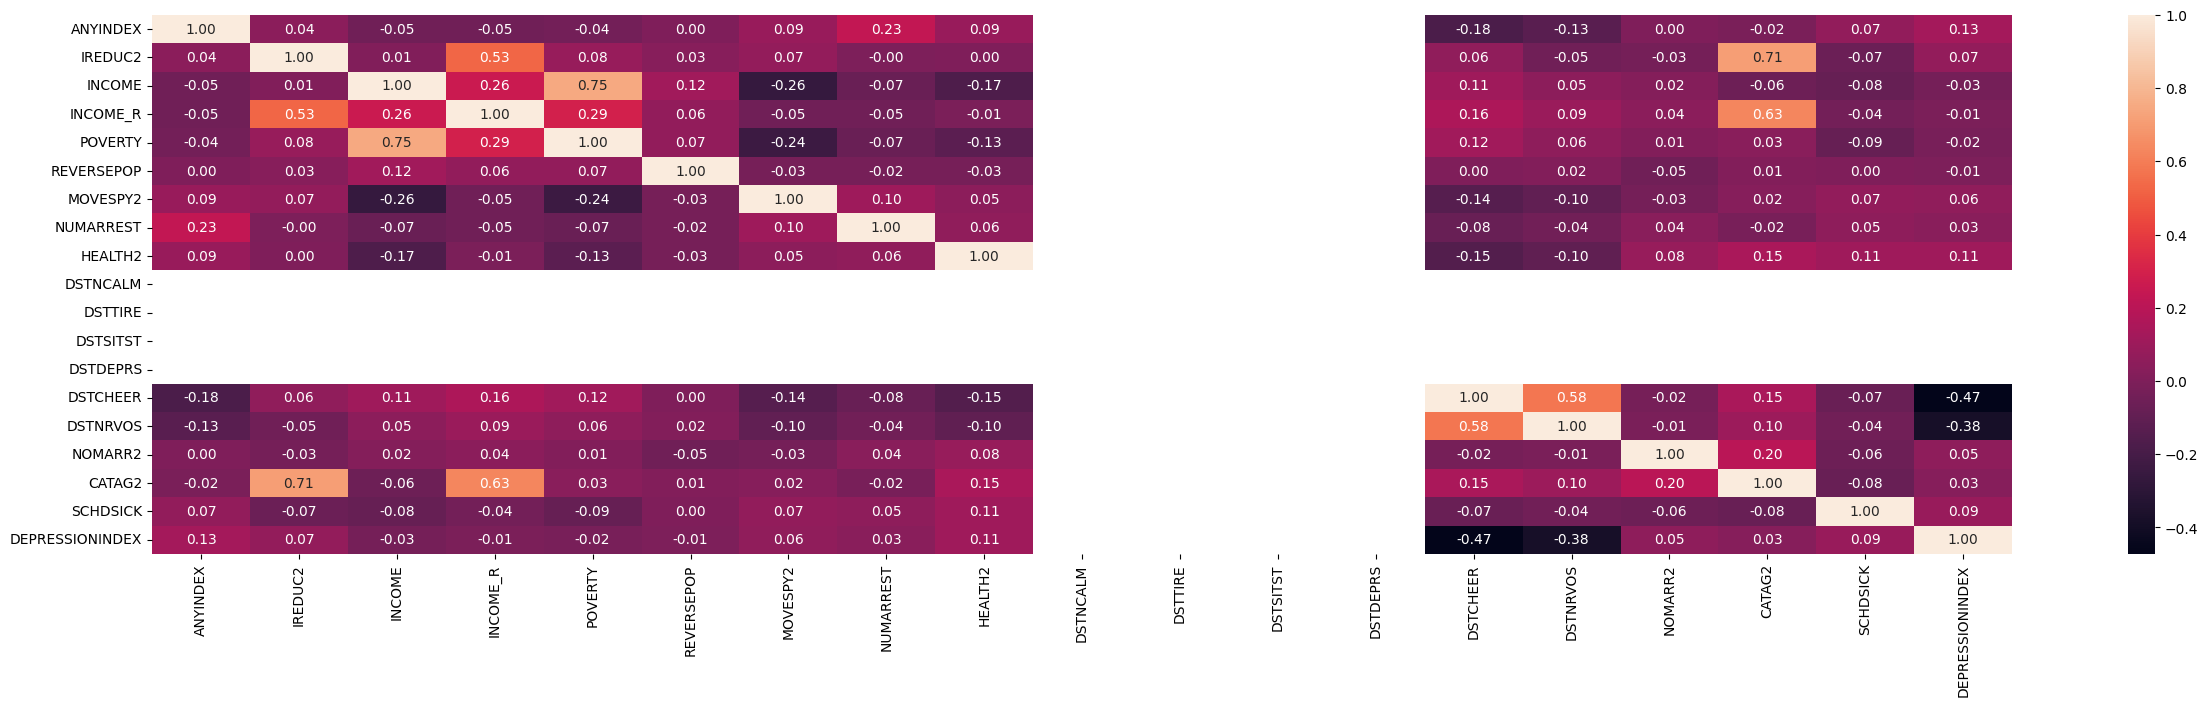

In [15]:
plt.figure(figsize=(30, 7))
sns.heatmap(pearson_df, annot=True, fmt=".2f")

<Axes: >

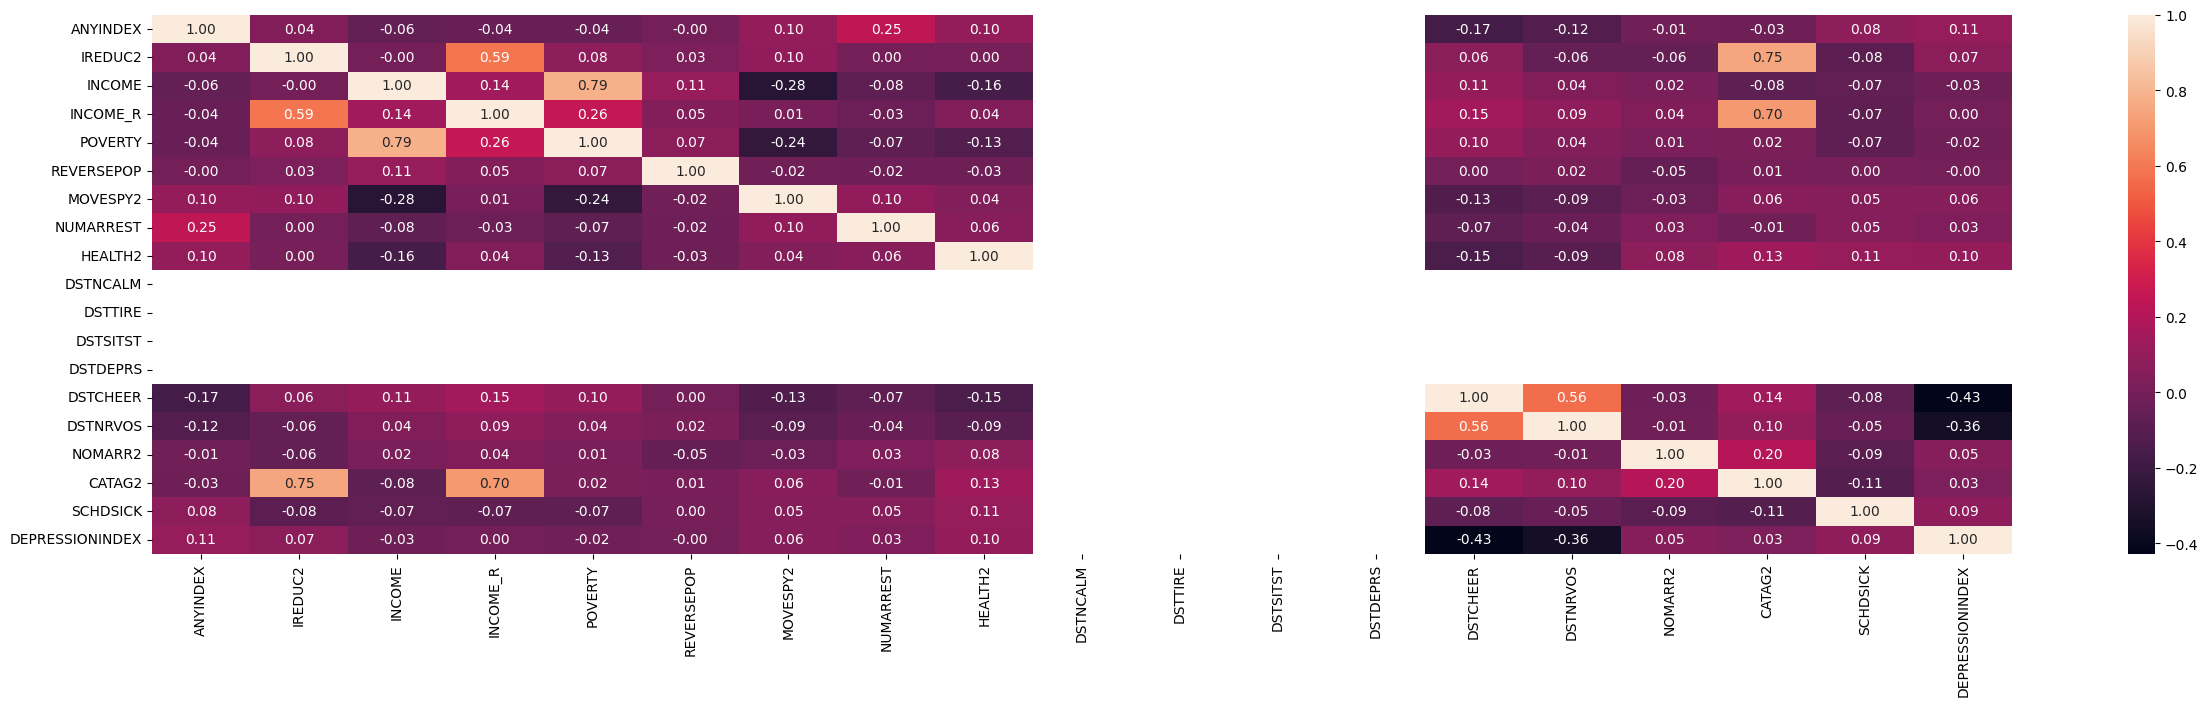

In [16]:
plt.figure(figsize=(30, 7))
sns.heatmap(spearman_df, annot=True, fmt=".2f")

<Axes: >

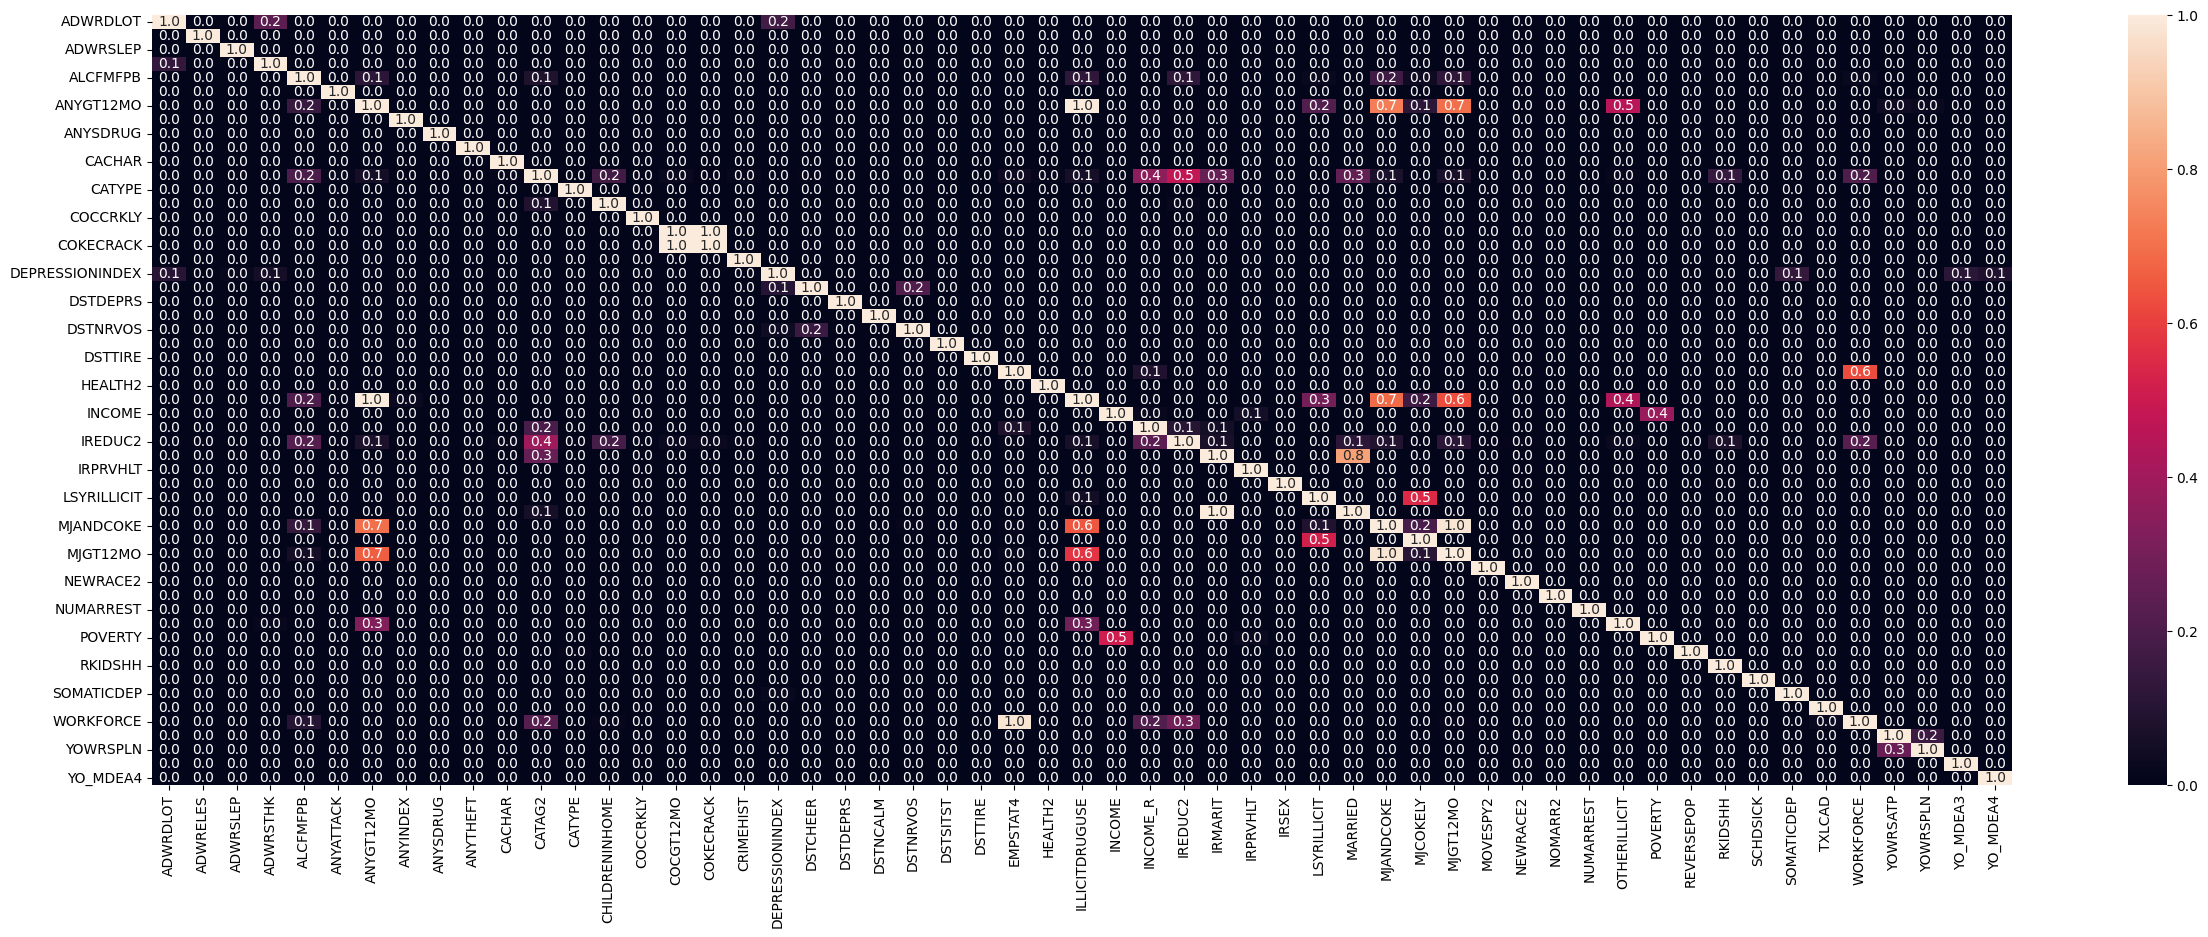

In [17]:
plt.figure(figsize=(30, 10)) # TODO: PPScore seems to have problem with None/NaN values
# probably interprets nans as seperate valuues and is unable to find correlation
sns.heatmap(pps_df, annot=True, fmt=".1f")  # Not sure about ths one

In [18]:
N = 8
COL = "DEPRESSIONINDEX"
print("Positive Correlation")
print(pearson_df[COL].drop(COL).nlargest(N))
print(spearman_df[COL].drop(COL).nlargest(N))
print()

print("Negative Correlation")
print(pearson_df[COL].drop(COL).nsmallest(N))
print(spearman_df[COL].drop(COL).nsmallest(N))
print()

print("Predictive Power Score")
print(pps_df[COL].drop(COL).nlargest(N))
print(pps_df.loc[COL].nlargest(N))
print()

Positive Correlation
ANYINDEX     0.130616
HEALTH2      0.112902
SCHDSICK     0.086127
IREDUC2      0.072569
MOVESPY2     0.061438
NOMARR2      0.054268
NUMARREST    0.033916
CATAG2       0.026986
Name: DEPRESSIONINDEX, dtype: float64
ANYINDEX     0.108115
HEALTH2      0.104804
SCHDSICK     0.087226
IREDUC2      0.068947
MOVESPY2     0.056894
NOMARR2      0.054757
NUMARREST    0.034625
CATAG2       0.025252
Name: DEPRESSIONINDEX, dtype: float64

Negative Correlation
DSTCHEER     -0.472218
DSTNRVOS     -0.384643
INCOME       -0.031572
POVERTY      -0.019779
INCOME_R     -0.010082
REVERSEPOP   -0.006300
CATAG2        0.026986
NUMARREST     0.033916
Name: DEPRESSIONINDEX, dtype: float64
DSTCHEER     -0.427799
DSTNRVOS     -0.355193
INCOME       -0.031781
POVERTY      -0.020303
REVERSEPOP   -0.003282
INCOME_R      0.001460
CATAG2        0.025252
NUMARREST     0.034625
Name: DEPRESSIONINDEX, dtype: float64

Predictive Power Score
ADWRDLOT      0.176357
DSTCHEER      0.098245
DSTNRVOS      0

### Analysis Performed For Different Groups

In [19]:
def split_by_col(df, col):
    categories = df[col].unique()
    categories.sort()
    dfs = {}
    for category in categories:
        dfs[f"{category}"] = df[df[col] == category].reset_index(drop=True)
    return dfs


def split_by_cols(df, cols):
    dfs = {}
    for col in cols:
        dfs[col] = split_by_col(df, col)
    return dfs

In [20]:
depression_dfs = split_by_cols(depression_df, ["IRSEX", age_col])